In [ ]:
pip install pot

In [20]:
import numpy as np
import ot
from libshare import sinkhorn_em_new,error,sinkhorn_np_logspace,create_K
import scipy
import sympy as sym
from sympy import lambdify

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import *
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
%matplotlib inline

# 5.1 Setting for Sensitivity Analaysis

We can focus on a mixture of two Gaussians and see how the adversarial approach compares to the MLE alternative.
Suppose
\begin{align}
    P_{\theta} = \alpha^* \delta_{\theta_1} + (1 - \alpha^*) \delta_{\theta_2}
\end{align}
And $c(x,y) = \|x - y\|^2 / 2\sigma^2$ so that
\begin{align}
    \hat P_{\theta} = \alpha^* \mathcal{N}(\theta_1, \sigma^2) + (1 - \alpha^*) \mathcal{N}(\theta_2, \sigma^2)
\end{align}

The question is what happens in model misspecification, where
\begin{align}
    \mu_Y = \overline{\alpha} \mathcal{N}(\theta_1, \sigma^2) + (1 - \overline{\alpha}) \mathcal{N}(\theta_2, \sigma^2)
\end{align}
and $|\alpha^* - \overline{\alpha}| < \varepsilon$. 

# 5.2 Sensitivity to Misspecification: Log-Likelihood

The likelihood is equal to
\begin{align}
    f(y, \theta) = \alpha^* \mathcal{N}(\theta, 1)(y) + (1 - \alpha^*)\mathcal{N}(-\theta, 1)(y)
\end{align}
Thus, by Theorem 5.1
\begin{align*}
    \theta'(0) &= (1-\alpha^*)^{-1} I^{-1}(\theta^*)s_{\theta}(\theta^*, \theta^*) \\
    &= (1-\alpha^*)^{-1} \left(\mathbb{E}_{Y \sim (F, G_{\theta^*})}-\dfrac{\partial^2 \log f}{\partial \theta^2}(Y, \theta^*) \right)^{-1} \mathbb{E}\left(l_{\theta}(Y, \theta^*) | Z = \theta^*\right)\\
    &= (1 - \alpha^*)^{-1} \left( \int_{\mathbb{R}} -\dfrac{\partial^2 \log f}{\partial \theta^2}(y, \theta^*) f(y, \theta) dy\right)^{-1} \int_{\mathbb{R}}  \dfrac{\partial \log f}{\partial \theta}(y, \theta^*) d\mathcal{N}(\theta^*, 1)(y)
\end{align*}

* Compute the theoretical formula, with sympy

In [6]:
# Define all parameters
import sympy as sym
alpha = sym.Symbol('alpha')
y =  sym.Symbol('y')
theta =  sym.Symbol('theta')
factor = 1 / sym.sqrt(2 * sym.pi)
N_plus = factor * sym.exp(- 0.5*(y - theta)**2)
N_minus = factor * sym.exp(- 0.5*(y + theta)**2)
f = alpha * N_plus + (1 - alpha) * N_minus
l = sym.log(f)
s = sym.diff(l, theta)
s_theta = sym.diff(s, theta)
I_integrand = -s_theta * f
s_integrand = s * N_plus

* Try to do symbolic computations (DO NOT RUN, DOES NOT FINISH):

In [ ]:
I = sym.integrate(I_integrand, (y, -sym.oo, sym.oo))
sym.simplify(I)
s_integral = sym.integrate(s_integrand, (y, -sym.oo, sym.oo))
theta_prime = (1 - alpha)**(-1) * I**(-1) * s_integral
theta_prime = sym.simplify(theta_prime)

In [ ]:
theta_prime.subs({alpha:0.4, theta:0.1})

**Does not work, sympy does not finish. Cannot find formula.**

* Let us just run numeric approximation of the formula (evaluate the integrals)

In [3]:
def eval_theta_prime_true(p_alpha, p_theta):
    I_integrand_func = sym.lambdify(y, I_integrand.subs({sym.Symbol('alpha'):p_alpha, sym.Symbol('theta'):p_theta}), 'numpy')
    s_integrand_func = sym.lambdify( y, s_integrand.subs({sym.Symbol('alpha'):p_alpha, sym.Symbol('theta'):p_theta}), 'numpy')
    I_inverse = 1 / scipy.integrate.quad(I_integrand_func, p_theta-25, p_theta+25)[0]
    s_integrated = scipy.integrate.quad(s_integrand_func, p_theta-25, p_theta+25)[0]
    return (1 - p_alpha)**(-1) * I_inverse * s_integrated


In [7]:
eval_theta_prime_true(0.4,0.1)

-0.6733382968319724

In [8]:
y_ = np.linspace(0.2, 1.5, 20)
x_ = np.linspace(0.5, 1., 10)
X_, Y_ = np.meshgrid(x_, y_)

In [9]:
def func(x, y):
    return theta_prime.subs({alpha:x, theta:y})

In [ ]:
Z_ = np.array([np.array([eval_theta_prime_true(X_[i][j], Y_[i][j]) for j in range(len(X_[0]))]) for i in range(len(X_)) ])

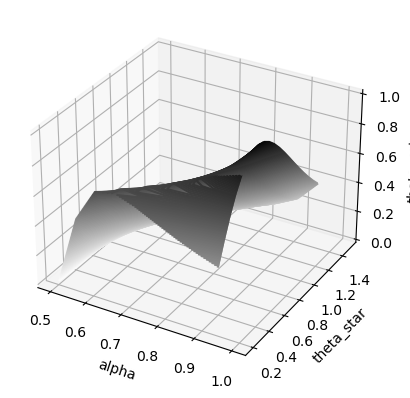

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X_, Y_, Z_, 200, cmap='binary')
ax.set_xlabel('alpha')
ax.set_ylabel('theta_star')
ax.set_zlabel('theta_prime');

* Nice plot. Let us now verify that the formula agrees with just straighforward computation with the lo likelihood

## Numerical calculation; verifying the formula is true

In [22]:
from sympy import lambdify

Popoulation log likelihood is
$$ ll(\alpha^*, \theta) = \mathbb{E}_{Y\sim Y_{law}} l_{\alpha^*}(y, \theta) $$
So we will just maximize this numerically over the tilted (true) distribution of the data.

In [23]:
# Does not work, impossible to compute symbolically
def get_population_ll(Y_law):
    return lambdify((alpha, theta), sym.integrate(l*Y_law, (y, -sym.oo, sym.oo)), 'numpy')

# lets do it the straightforward way
log_likelihood = lambdify((alpha, y, theta), l, 'numpy')
Y_law = lambdify((alpha, y, theta), f, 'numpy')

In [24]:
l

log(sqrt(2)*alpha*exp(-0.5*(-theta + y)**2)/(2*sqrt(pi)) + sqrt(2)*(1 - alpha)*exp(-0.5*(theta + y)**2)/(2*sqrt(pi)))

We can't have the negative exponential be evaluated to infinity. thus we will restrict bounds of integration to $\theta-25,\theta+25$

In [25]:
def eval_population_ll(alpha_true, theta_true, alpha, theta):
    return scipy.integrate.quad(lambda y: log_likelihood(alpha, y, theta)*Y_law(alpha_true, y, theta_true), theta-25, theta+25)

In [26]:
eval_population_ll(0.65,1, 0.65, 0.6)

(-1.7825426429803657, 2.506622611595126e-11)

* Let us verify that this recovers the true parameter in well specified setting:

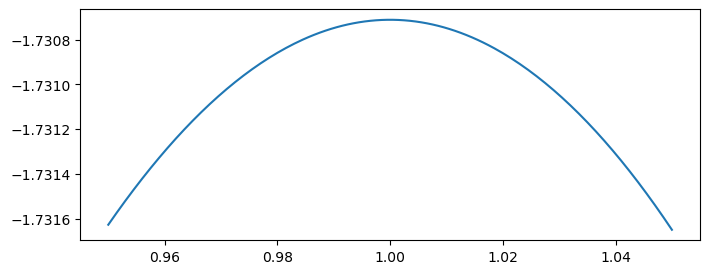

1.0


In [27]:
tmp_x = np.linspace(0.95,1.05, 201)
tmp_y = np.array([eval_population_ll(0.65,1, 0.65, x)[0] for x in tmp_x])

plt.figure(figsize=(8,3))
plt.plot(tmp_x, tmp_y)
plt.show()
print(tmp_x[np.argmax(tmp_y)])

* Ok, recovers the true theta. Now, add some tilting:

In [28]:
tmp_x = np.linspace(0.95,1.05, 201)
tmp_y = np.array([eval_population_ll(0.65,1, 0.68, x)[0] for x in tmp_x])

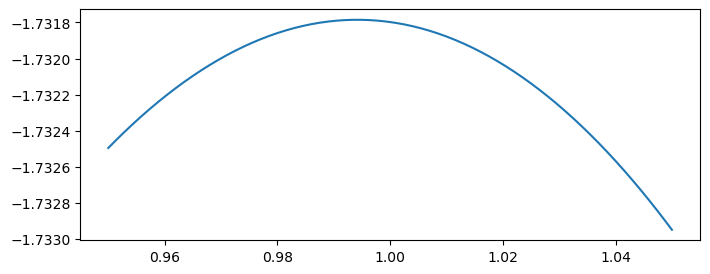

0.994


In [29]:
plt.figure(figsize=(8,3))
plt.plot(tmp_x, tmp_y)
plt.show()
print(tmp_x[np.argmax(tmp_y)])

* Nice. Lets plot the derivative

In [30]:
# minimizing to obtain ll estimation
scipy.optimize.fmin(lambda x: -eval_population_ll(0.65,1, 0.68, x)[0], 1, disp=False)[0]

0.994140625

In [34]:
# evaluate at a specified alpha
def eval_ll_gmm(alpha_true, theta_true, alpha):
    return scipy.optimize.fmin(lambda x: -eval_population_ll(alpha_true,theta_true, alpha, x)[0], theta_true, disp=False)[0]

# evaluate the derivative, finite difference, (+eps, -eps)
def eval_theta_prime(alpha_true, theta, eps= 1e-3):
    m_eps_minus = scipy.optimize.fmin(lambda x: -eval_population_ll(alpha_true-eps,theta, alpha_true, x)[0], theta, disp=False)[0]
    m_eps_plus = scipy.optimize.fmin(lambda x: -eval_population_ll(alpha_true+eps, theta, alpha_true, x)[0], theta, disp=False)[0]
    return (m_eps_plus - m_eps_minus) / (2*eps)

In [35]:
eval_ll_gmm(0.75, 1.0, 0.7)

1.0105468749999997

In [36]:
eval_theta_prime(0.6, 1)

0.0976562499999667

* Compute a few parameters. Can pickle load them if needed

In [43]:
tmp_theta = np.linspace(0.0, 0.75, 25)
alphas=np.linspace(0.55,0.95, 5)
tmp_theta_prime = []
for alpha in alphas:
    tmp_theta_prime.append([eval_theta_prime(alpha, theta, 1e-2) for theta in tmp_theta])

In [44]:
import pickle
with open('theta_prime_mle', 'wb') as handle:
    pickle.dump(tmp_theta_prime, handle)

* Display

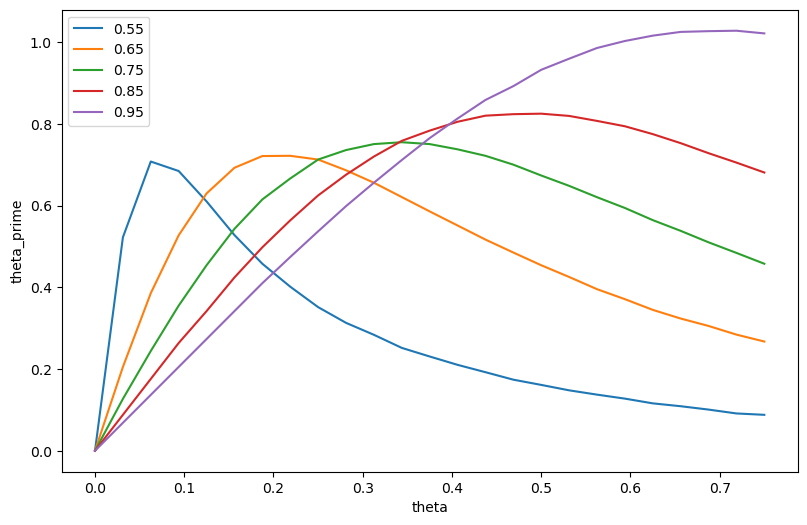

In [45]:
plt.figure(figsize=(9.5,6))
for i, alpha in enumerate(alphas):
    plt.plot(tmp_theta, tmp_theta_prime[i], label=int(alpha*100)/100)
plt.xlabel('theta')
plt.ylabel('theta_prime')
plt.legend(loc='best')
plt.show()

# 5.3 Sensitivity to Misspecification: Semi-Dual EOT

Remember the formula 
\begin{align}
    \theta_{EOT} &= \arg\max_{\theta} \inf_f
    D(\alpha_{\theta} \parallel \alpha_{\theta, f}) + \mathbb{E}_{Y\sim \beta}(\log L \ast \alpha_{\theta, f}(Y))
    \label{eq:robust_family}
\end{align}
Now, we are in the setting where $Y = X + Z$, $X \sim \alpha^{*} \delta_{\theta} + (1-\alpha^{*}) \delta_{-\theta}$, $Z = \mathcal{N}(0,1)$. Thus



\begin{align*}
d \alpha_{\theta} &= \alpha^{*} d \delta_{\theta} + (1-\alpha^{*}) d \delta_{-\theta} \\ 
d \alpha_{\theta, f} &= h d \delta_{\theta} + (1-h) d \delta_{-\theta}, \quad h = h(f) \\ 
L(x) &= e^{-c(x)} \\
d\beta(y) &= \alpha^{*}e^{-c(y - \theta^*)} + (1-\alpha^{*})e^{-c(y + \theta^*)}
\end{align*}

$$ \theta_{EOT} = \text{argmax}_{\theta} \inf_h \left[\alpha^*\log(\dfrac{\alpha^*}{h}) + (1-\alpha^*)\log(\dfrac{1-\alpha^*}{1-h}) + \int_y \log(h e^{-c(y - \theta)} + (1-h)e^{-c(y + \theta)} ) d\beta(y) \right]$$

- Can we find a formula for $h$ ?

In [46]:
import sympy as sym
alpha = sym.Symbol('alpha')
y =  sym.Symbol('y')
theta =  sym.Symbol('theta')
h =  sym.Function('h')(theta)



factor = 1 / sym.sqrt(2 * sym.pi)
N_plus = sym.simplify(factor * sym.exp(- 0.5*(y - theta)**2))
N_minus = sym.simplify(factor * sym.exp(- 0.5*(y + theta)**2))
beta = sym.simplify(alpha * N_plus + (1 - alpha) * N_minus)

first_term = alpha * sym.log(alpha / h) + (1 - alpha) * sym.log((1 - alpha) / (1 - h))
integrand = sym.log(h * N_plus + (1 - h) * N_minus)

* Some symbolic computations

In [98]:
tmp = sym.simplify(sym.diff(sym.simplify(sym.diff(integrand, theta)), theta))
tmp

(-((1.0*(theta - y)*h(theta) - Derivative(h(theta), theta))*exp(0.5*(theta + y)**2) + (-1.0*(theta + y)*(h(theta) - 1) + Derivative(h(theta), theta))*exp(0.5*(theta - y)**2))*(1.0*(theta - y)*(h(theta) - 1)*exp(0.5*(theta - y)**2) - 1.0*(theta + y)*h(theta)*exp(0.5*(theta + y)**2) + exp(0.5*(theta - y)**2)*Derivative(h(theta), theta) - exp(0.5*(theta + y)**2)*Derivative(h(theta), theta)) + ((h(theta) - 1)*exp(0.5*(theta - y)**2) - h(theta)*exp(0.5*(theta + y)**2))*(-1.0*(theta - y)*(1.0*(theta + y)*(h(theta) - 1) - Derivative(h(theta), theta))*exp(0.5*(theta - y)**2) + 1.0*(theta + y)*(1.0*(theta - y)*h(theta) - Derivative(h(theta), theta))*exp(0.5*(theta + y)**2) + (1.0*(theta - y)*Derivative(h(theta), theta) + 1.0*h(theta) - Derivative(h(theta), (theta, 2)))*exp(0.5*(theta + y)**2) + (-1.0*(theta + y)*Derivative(h(theta), theta) - 1.0*h(theta) + Derivative(h(theta), (theta, 2)) + 1.0)*exp(0.5*(theta - y)**2)))/((h(theta) - 1)*exp(0.5*(theta - y)**2) - h(theta)*exp(0.5*(theta + y)**2)

* Closed form formula? **No**

In [47]:
sym.simplify(sym.diff(integrand, h))

(exp(2.0*theta*y) - 1)/(h(theta)*exp(2.0*theta*y) - h(theta) + 1)

In [48]:
first_term

alpha*log(alpha/h(theta)) + (1 - alpha)*log((1 - alpha)/(1 - h(theta)))

In [50]:
d_integrand = sym.simplify(sym.diff(first_term, theta))
sym.simplify(sym.diff(d_integrand, theta))

((-alpha + h(theta))*(h(theta) - 1)*Derivative(h(theta), theta)**2 + (-alpha + h(theta))*h(theta)*Derivative(h(theta), theta)**2 + ((alpha - h(theta))*Derivative(h(theta), (theta, 2)) - Derivative(h(theta), theta)**2)*(h(theta) - 1)*h(theta))/((h(theta) - 1)**2*h(theta)**2)

In [ ]:
d_second_term = sym.simplify(sym.integrate(sym.simplify(d_integrand * beta), (y, -sym.oo, sym.oo)))

In [ ]:
result = sym.solve(sym.simplify(sym.diff(first_term, h)) + d_second_term)

In [ ]:
second_term = sym.integrate(integrand, (y, -2, 2))

argument = first_term + second_term

## Numerical computations (before looking at the theoretical forumla)

$$ \theta_{EOT} = \text{argmax}_{\theta} \inf_h \left[\alpha^*\log(\dfrac{\alpha^*}{h}) + (1-\alpha^*)\log(\dfrac{1-\alpha^*}{1-h}) + \int_y \log(h e^{-c(y - \theta)} + (1-h)e^{-c(y + \theta)} ) d\beta(y) \right]$$

In [51]:
# returns the value of the equation with a specified theta and h
def eot_semi_dual(alpha, theta_star, theta, h):
    return alpha*np.log(alpha / h) + (1-alpha)*np.log((1-alpha)/(1 - h)) \
        + scipy.integrate.quad(lambda x : np.log((h * np.exp(-(x - theta)**2) + (1-h) * np.exp(-(x + theta)**2))/(np.sqrt(2*np.pi)))
                                                * (alpha * np.exp(-(x - theta_star)**2) + (1-alpha) * np.exp(-(x + theta_star)**2))/(np.sqrt(2*np.pi))
                              , theta_star - 20,  theta_star + 20)[0]

In [52]:
eot_semi_dual(0.5,1,1,0.7)

-1.3167147983075311

In [55]:
scipy.optimize.minimize(lambda x: eot_semi_dual(0.6, 1, 1, x), 0.55)

      fun: -1.346004836023369
 hess_inv: array([[0.52415516]])
      jac: array([-2.08616257e-07])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.59999988])

**OK. Without misspecification, minimum over h is alpha star, and we recover log likelihood objective function.**

* Now, introduce misspecification

In [84]:
# now allow for mispecification in the equation
def eot_semi_dual_misspecified(alpha, eps, theta_star, theta, h):
    return alpha*np.log(alpha / h) + (1-alpha)*np.log((1-alpha)/(1 - h)) \
        + scipy.integrate.quad(lambda x : np.log((h * np.exp(-(x - theta)**2) + (1-h) * np.exp(-(x + theta)**2))/(np.sqrt(2*np.pi)))
                                                * ((alpha+eps) * np.exp(-(x - theta_star)**2) + (1-alpha - eps) * np.exp(-(x + theta_star)**2))/(np.sqrt(2*np.pi))
                              , theta_star - 20,  theta_star + 20)[0]

# returns the minimizing value h: argmin_h
def h(alpha, eps, theta_star, theta):
    return scipy.optimize.minimize(lambda x: eot_semi_dual_misspecified(alpha,eps, theta_star, theta, x), 
                                    alpha, bounds= scipy.optimize.Bounds(1e-5,1.0-1e-5))['x'][0]

# returns the minimum over all h: min_h
def inf_h_eot(alpha, eps, theta_star, theta):
    return scipy.optimize.minimize(lambda x: eot_semi_dual_misspecified(alpha,eps, theta_star, theta, x), alpha,
                                  bounds= scipy.optimize.Bounds(1e-5,1.0-1e-5))['fun']

In [54]:
scipy.optimize.minimize(lambda x: eot_semi_dual_misspecified(0.95,.01, 1, 1, x), 0.5, bounds= scipy.optimize.Bounds(1e-5,1.0-1e-5))

      fun: -1.0809759678004613
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.62092561e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 7
     njev: 12
   status: 0
  success: True
        x: array([0.94219542])

In [57]:
h(0.896, -0.01, 1, 1.2)

0.9146747501254553

**Yes! Now h is not alpha star, which is good news. Let us continue**

In [85]:
# Returns the actual semi-dual estimator
def theta_eot(alpha, eps, theta_star):
    return scipy.optimize.minimize(lambda x: -inf_h_eot(alpha,eps, theta_star, x), 1)['x'][0]

In [60]:
theta_eot(0.95, -0.01, 1)

0.9938490009377408

**this is working**

In [87]:
# evaluate derivative. When notmisspecified, remember we recover the true parameter
def eval_theta_prime_eot(alpha, theta, eps= 1e-2):
    return (theta_eot(alpha, eps, theta) - theta) / (eps)

In [63]:
eval_theta_prime_eot(0.98, 1, 1e-2)

0.7311987125399044

* Compute

In [261]:
tmp_theta = np.concatenate((np.linspace(0.0, 0.4, 20), np.linspace(0.4, 1.2, 20)))# np.linspace(0.0, 1.2, 20)
alphas=np.linspace(0.55,0.95, 9)
tmp_theta_prime = []
for alpha in alphas:
    tmp_theta_prime.append([eval_theta_prime_eot(alpha, theta, 1e-2) for theta in tmp_theta])

* Plot

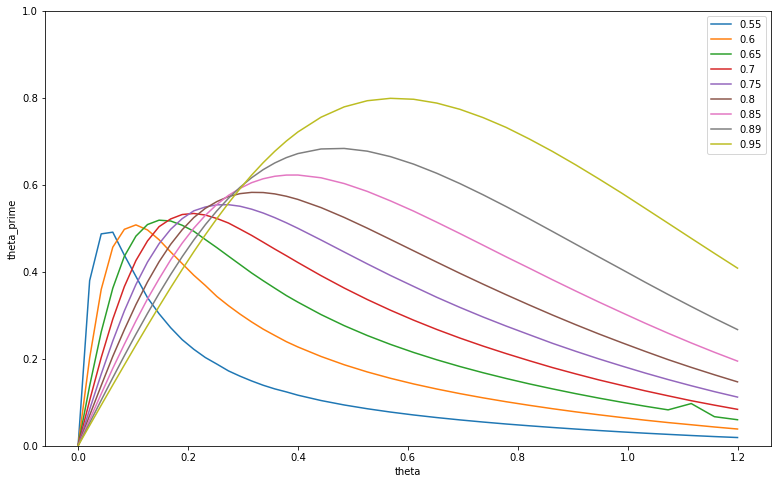

In [262]:
plt.figure(figsize=(13,8))
for i, alpha in enumerate(alphas):
    plt.plot(tmp_theta, tmp_theta_prime[i], label=int(alpha*100)/100)
plt.xlabel('theta')
plt.ylabel('theta_prime')
plt.ylim(0,1)
plt.legend(loc='best')
plt.show()

* Compare with log likelihood

<IPython.core.display.Javascript object>


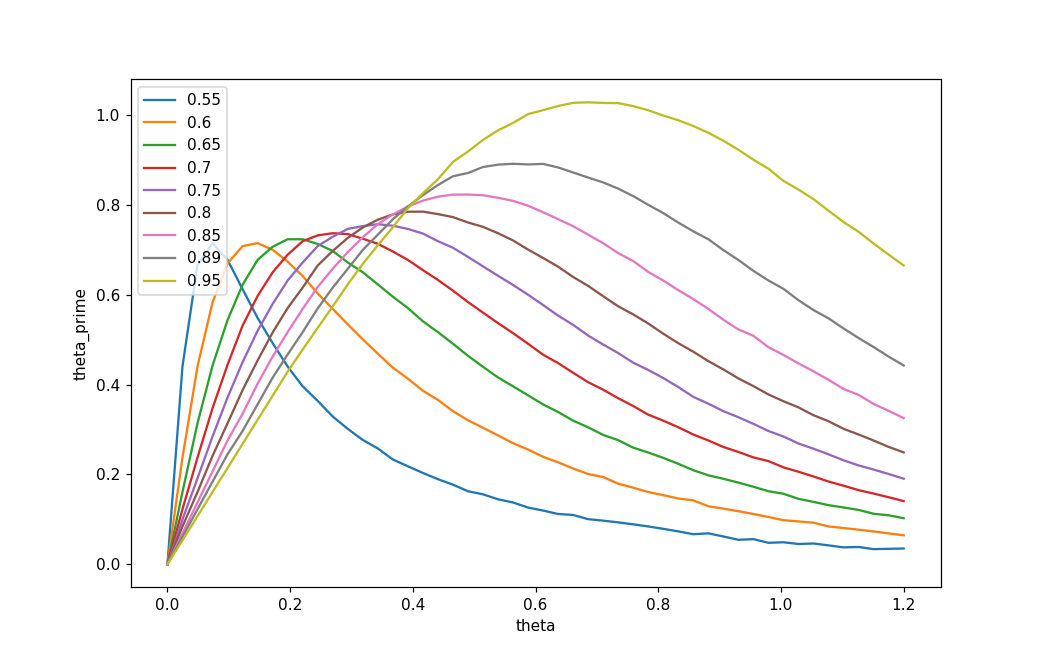

In [298]:
plt.figure(figsize=(9.5,6))
for i, alpha in enumerate(alphas):
    plt.plot(tmp_theta, tmp_theta_prime[i], label=int(alpha*100)/100)
plt.xlabel('theta')
plt.ylabel('theta_prime')
plt.legend(loc='best')
plt.show()

This is clearly better. We will provide some other plots later on, when looking at simulations with EM and Sinkhorn EM.

## Compare with the theoretical formula now

\begin{align*}
    \theta'(0) &= I_s^{-1}(\theta^*) \left[ 
     \dfrac{(\alpha^* - h(\theta))h'(\theta)}{(h(\theta) - 1)h(\theta)}
     + \int_{\mathcal{Y}}\left(\dfrac{\partial}{\partial \theta}\log h(\theta) e^{-c(y - \theta)} + (1-h(\theta)) e^{-c(y + \theta)} \right)d\mathcal{N}(\theta^*, 1)(y) 
     \right]
     \\ 
     &= I_s^{-1}(\theta^*) \bigg (
     \dfrac{(\alpha^* - h(\theta))h'(\theta)}{(h(\theta) - 1)h(\theta)} \\ 
     &+ \int_{\mathcal{Y}}\left(
        \frac{ h'(\theta)(e^{-c(y - \theta)} - e^{-c(y + \theta)}) 
                }
        {h(\theta) e^{-c(y - \theta)} + (1-h(\theta)) e^{-c(y + \theta)} }
        \right)d\mathcal{N}(\theta^*, 1)(y) \\
    &+ \int_{\mathcal{Y}}\left(
        \frac{ 
                - 2h(\theta)((y - \theta)e^{-c(y - \theta)} - (y + \theta)e^{-c(y + \theta)})
                }
        {h(\theta) e^{-c(y - \theta)} + (1-h(\theta)) e^{-c(y + \theta)} }
        \right)d\mathcal{N}(\theta^*, 1)(y) \\
    &+ \int_{\mathcal{Y}}\left(
    \frac{ 
            - 2(y + \theta)e^{-c(y + \theta)}
            }
    {h(\theta) e^{-c(y - \theta)} + (1-h(\theta)) e^{-c(y + \theta)} }
    \right)d\mathcal{N}(\theta^*, 1)(y)
     \bigg)
\end{align*}
Further, we have of course
\begin{align*}
    I_s(\theta) &= \dfrac{
        (h(\theta) - \alpha^*)(h(\theta)-1)h'(\theta)^2 
        + (h(\theta) - \alpha)h(\theta)h'(\theta)^2 
        + [(\alpha - h(\theta))h''(\theta) - h'(\theta)^2](h(\theta)-1)h(\theta)}
    {(h(\theta) - 1)^2 h(\theta)^2}
    \\
    &+ \int_{\mathcal{Y}} \left( \dfrac{\partial^2}{\partial \theta^2}\log h(\theta) e^{-c(y - \theta)} + (1-h(\theta)) e^{-c(y + \theta)}\right) d \left(\alpha^*\mathcal{N}(\theta^*, 1) + (1-\alpha^*)\mathcal{N}(-\theta^*, 1)\right)(y)
\end{align*}
which determines the value of $\theta'(0)$. 

I think here the values of $h$ are determined for $\varepsilon = 0$ (with respect to the unperturbed measure)

In [64]:
# We wont actually need this, we will rely on scipy/numpy for differentiation 
def h_prime(alpha, eps, theta_star, theta):
    return scipy.misc.derivative(lambda x: h(alpha, eps, theta_star, x), theta, dx=1e-3, n=1)

def h_second(alpha, eps, theta_star, theta):
    return scipy.misc.derivative(lambda x: h(alpha, eps, theta_star, x), theta, dx=1e-3, n=2)

In [88]:
def N_plus(theta_star, x):
    return  np.exp(-(x - theta_star)**2)/(np.sqrt(2*np.pi))

def beta(alpha, eps, theta_star, x):
    return ((alpha+eps) * np.exp(-(x - theta_star)**2) + (1-alpha - eps) * np.exp(-(x + theta_star)**2))/(np.sqrt(2*np.pi))

def integrand(alpha, theta_star, theta, x):
    val = h(alpha, 0.0, theta_star, theta)
    return np.log( (val * np.exp(-(x - theta)**2) + (1-val) * np.exp(-(x + theta)**2) )/(np.sqrt(2*np.pi)))

def integrand_prime(alpha, theta_star, theta, x):
    return scipy.misc.derivative(lambda t: integrand(alpha, theta_star, t, x), theta, dx=1e-4, n=1)
    
def integrand_second(alpha, theta_star, theta, x):
    return scipy.misc.derivative(lambda t: integrand(alpha, theta_star, t, x), theta, dx=1e-4, n=2)

def kl_term(alpha, theta_star, theta):
    val = h(alpha, 0.0, theta_star, theta)
    return alpha*np.log(alpha/val) + (1-alpha)*np.log((1-alpha)/(1-val))

In [89]:
def info_matrix_eot(alpha, theta_star, theta):
    return -scipy.misc.derivative(lambda x: kl_term(alpha, theta_star, x), theta, dx=1e-4, n=2) - \
    scipy.integrate.quad(lambda x: integrand_second(alpha, theta_star, theta, x)*beta(alpha, 0.0, theta_star, x), theta_star-15, theta_star+15)[0]

In [90]:
def sensitivity_terms(alpha, theta_star, theta):
    return scipy.misc.derivative(lambda x: kl_term(alpha, theta_star, x), theta, dx=1e-4, n=1) + \
    scipy.integrate.quad(lambda x: integrand_prime(alpha, theta_star, theta, x)*N_plus(theta_star, x), theta_star-15, theta_star+15)[0]

In [ ]:
# And finally compute our formula
def theta_prime_eot_formula(alpha, theta_star):
    return sensitivity_terms(alpha,theta_star,theta_star) / ((1-alpha)*info_matrix_eot(alpha,theta_star,theta_star))

* Now run everything. **Beware, this is a bit long**

In [68]:
info_matrix_eot(0.6, 1,1)

1.2685436156992365

In [69]:
sensitivity_terms(0.6,1,1)

0.014765763018745381

In [71]:
theta_prime_eot_formula(0.95, 0.6)

0.7980395108249343

* It takes a **long time** to run.

In [ ]:
tmp_theta = np.concatenate((np.linspace(0.0, 0.4, 10), np.linspace(0.4, 1.2, 10)))# np.linspace(0.0, 1.2, 20)
alphas=np.linspace(0.55,0.95, 5)
tmp_theta_prime = []
for alpha in alphas:
    tmp_theta_prime.append([theta_prime_eot_formula(alpha, theta) for theta in tmp_theta])

In [ ]:
%matplotlib inline

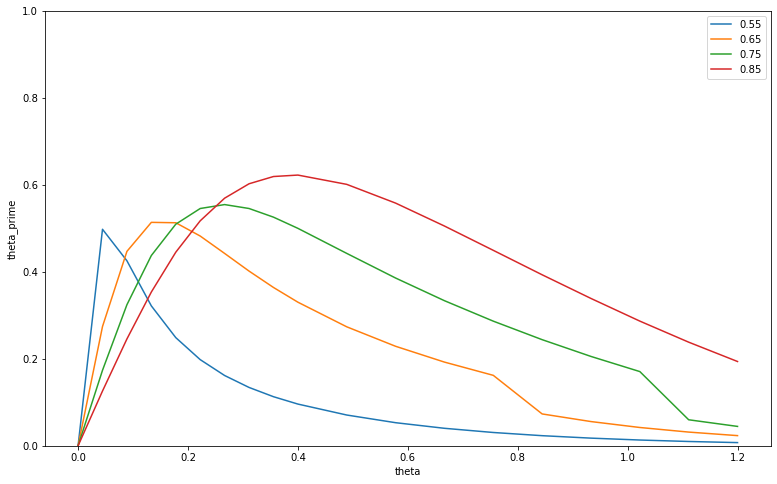

In [260]:
plt.figure(figsize=(13,8))
for i, alpha in enumerate(alphas[:4]):
    plt.plot(tmp_theta, (1-alpha)**(-1) * np.array(tmp_theta_prime[i]), label=int(alpha*100)/100)
plt.xlabel('theta')
plt.ylabel('theta_prime')
plt.ylim(0,1)
plt.legend(loc='best')
plt.show()

dont forget to multiply by inverse of 1 - alpha!

# MLE vs EOT; EM and Sinkhorn EM

\begin{align}
    \theta_{EOT} &= \arg\max_{\theta} \inf_f
    D(\alpha_{\theta} \parallel \alpha_{\theta, f}) + \mathbb{E}_{Y\sim \beta}(\log L \ast \alpha_{\theta, f}(Y))
    \label{eq:robust_family}
\end{align}
Now, we are in the setting where $Y = X + Z$, $X \sim \alpha^{*} \delta_{\theta} + (1-\alpha^{*}) \delta_{-\theta}$, $Z = \mathcal{N}(0,1)$. Thus
\begin{align*}
d \alpha_{\theta} &= \alpha^{*} d \delta_{\theta} + (1-\alpha^{*}) d \delta_{-\theta} \\ 
d \alpha_{\theta, f} &= h d \delta_{\theta} + (1-h) d \delta_{-\theta}, \quad h = h(f) \\ 
L(x) &= e^{-c(x)} \\
d\beta(y) &= \alpha^{*}e^{-c(y - \theta)} + (1-\alpha^{*})e^{-c(y + \theta)}
\end{align*}

## Experiments

* Just plotting results of a previous run to show what each methods looks like. DO NOT RUN THIS CODE.

sinkhorn:	 [ 2.97477542 -2.93030242] 
em:		 [ 2.98900602 -2.89619077]


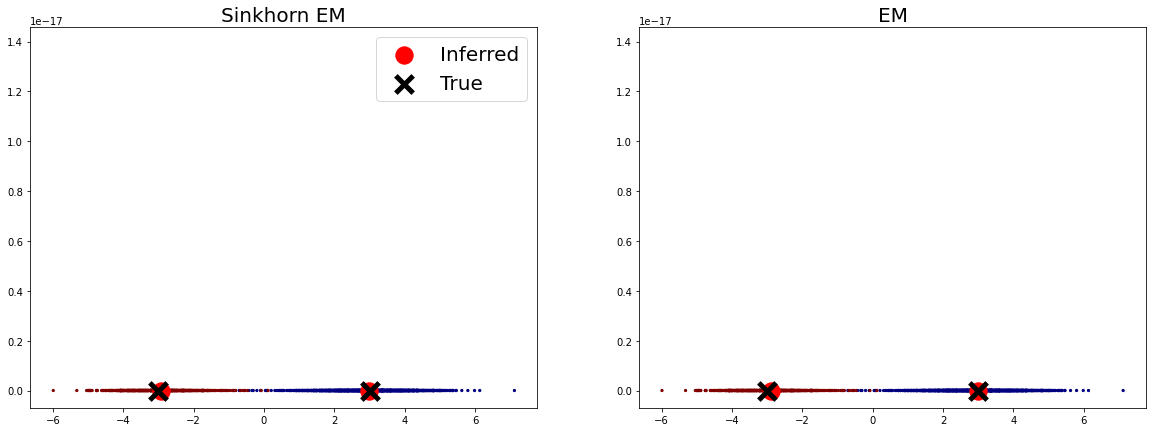

In [292]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

for i in range(2):
    ax[i].scatter(datas2[0,:],np.zeros(datas2[0,:].shape),5,classes,cmap='jet')
    ax[i].scatter(mus[:,0],np.zeros(mus[:, 0].shape),100,marker='x',color='black')

    
ax[0].scatter(lowest_mu_sinkhorn,np.zeros(mu_sinkhorn[:,0].shape),300,marker='o',color='red',label='Inferred')
ax[0].set_title('Sinkhorn EM',fontsize=20)
ax[1].scatter(lowest_mu_em,np.zeros(mu_em[:,0].shape),300,marker='o',color='red')
ax[1].set_title('EM',fontsize=20)
for i in range(2):
     ax[i].scatter(mus[:,0],np.zeros(mus[:, 0].shape),300,marker='x',color='black',linewidth=5,label='True')
ax[0].legend(fontsize=20,frameon=True)

print('sinkhorn:\t',np.ravel(lowest_mu_sinkhorn[::-1]), '\nem:\t\t', np.ravel(lowest_mu_em))
plt.show()

## Sensitivity analyisis: simulation to get $\theta'_{\alpha}(0)$ experimentally

Adapt the initial code the following way. Slightly readapted to take into account only one dimension. Seems like proprotion values (pis) are inverted for sinkhorn and classical em

In [74]:
import numpy as np
import ot
from libshare import sinkhorn_em_new,error,sinkhorn_np_logspace,create_K
import scipy

import matplotlib.pyplot as plt
from sklearn import *
from scipy.stats import ortho_group
import matplotlib.pyplot as plt

import tqdm
import random

In [95]:
def generate_data(alpha, eps, theta, N):
    M = 2
    D = 1
    np.random.seed(None)
    random.seed(None)
    sigmas0 =  np.zeros((M , D, D))
    sigmas =  np.zeros((M , D, D))
    mus = np.zeros((M,D,1))
    for k in range(M):
        sigmas0[k,:,:] = np.eye(D)
        sigmas[k,:,:] = np.eye(D)
        mu = np.ones(shape=(D, 1)) *(theta)*(-1)**k
        mus[k,:,:] = mu
    
    pis = np.array([alpha, 1-alpha])
    pis_data = np.array([alpha + eps, 1-alpha - eps])

    datas = np.array([])
    classes = np.array([])
    for n in range(M):
        m = round(pis_data[n]*N)
        data = mus[n,:,0] + np.matmul(sigmas0[n,:,:],np.random.normal(0,1,size=(m,D)).T).T
        datas= np.append(datas,data)
        classes= np.append(classes, np.zeros(m)+n)
    datas2=np.array(datas).reshape(N, 1).T
    classes=np.array(classes).flatten()
    return datas2, classes

# Returns the best run for EM and Sinkhorn EM.
# alpha is the (misspecified) model, alpha + eps identifies the true data distribution
# itr_num number of iterations in the EM algorithm, 
# total_runs is the number of runs from randomly initialized points.
def simulate(alpha, eps, theta, N=1000, itr_num=15, total_runs=5, disp=True, tq=True):
    
    # The true theta to be found by the method.
    theta_to_be_found_em =eval_ll_gmm(alpha + eps, theta, alpha)
    theta_to_be_found_sinkhorn = theta_eot(alpha, eps, theta)
    
    if (disp):
        print('should find: ', theta_to_be_found_sinkhorn, '(EOT)\t', theta_to_be_found_em, '(MLE)')
    
    mu_to_find_em = np.array([np.array([theta_to_be_found_em*(-1)**i]) for i in range(2)])
    mu_to_find_sinkhorn = np.array([np.array([theta_to_be_found_sinkhorn*(-1)**i]) for i in range(2)])

    M = 2
    D = 1
    np.random.seed(None)
    random.seed(None)
    sigmas0 =  np.zeros((M , D, D))
    sigmas =  np.zeros((M , D, D))
    mus = np.zeros((M,D,1))
    for k in range(M):
        sigmas0[k,:,:] = np.eye(D)
        sigmas[k,:,:] = np.eye(D)
        mu = np.ones(shape=(D, 1)) *(theta)*(-1)**k
        mus[k,:,:] = mu
    
    pis = np.array([alpha, 1-alpha])
    pis_data = np.array([alpha + eps, 1-alpha - eps])

    datas = np.array([])
    classes = np.array([])
    for n in range(M):
        m = round(pis_data[n]*N)
        data = mus[n,:,0] + np.matmul(sigmas0[n,:,:],np.random.normal(0,1,size=(m,D)).T).T
        datas= np.append(datas,data)
        classes= np.append(classes, np.zeros(m)+n)
    datas2=np.array(datas).reshape(N, 1).T
    classes=np.array(classes).flatten()
    
    mus_sinkhorn = []
    mus_em = []
    mus_km =[]

    lowest_mu_sinkhorn = None
    lowest_mus_sinkhorn = None
    lowest_error_sinkhorn = 50
    lowest_mu_em = None
    lowest_mus_em = None
    lowest_error_em = 50

    for s in (tqdm.trange(total_runs) if tq else range(total_runs)):
        np.random.seed(None)
        random.seed(None)#np.random.seed(s)
        for k in range(M):
            #mu = np.ones(shape=(D, 1)) *(theta * (1+0.01*random.random()) )*(-1)**k
            mu = np.ones(shape=(D, 1)) *(theta_to_be_found_em*(1+0.2*random.random()))*(-1)**k
            mus[k,:,:] = mu
        update = {'pi':False,'mu':True,'sigma':False}
        #update all parameters
        var0 =  {'pi':pis,'mu':mus, 'sigma':sigmas}#
        #random initial values for all quantities (uniform weights)

        pi_em, mu_em, sigma_em,mu_all_em,H_em,liks_em,_,sigma_all_em,pi_all_em,somethign,props = sinkhorn_em_new(datas2,M,itr_num=itr_num,seed=s,var0 =var0,
                                                                                               update = update,tol=1e-20,
                                                                             update_em_pi=False, 
                                                                             do_sinkhorn=False,tol_sigma=1e-1, init_mu_type='subsample')

        pi_sinkhorn, mu_sinkhorn, sigma_sinkhorn,mu_all_sinkhorn,H_sinkhorn,liks_sinkhorn,sinkhorn_loss,sigma_all_sinkhorn,pi_all_sinkhorn,ho,prop = \
            sinkhorn_em_new(datas2,M,itr_num=itr_num,
                   seed=s,var0 =var0,update = update,tol=1e-20,
                    update_em_pi=True,do_sinkhorn=True,tols=1e-5,
                    n_iter_sink = 100,tol_sigma=1e-2,init_mu_type='subsample')

        

        #err_em = error(mu_em,mus[:,:,0],pi_em,pis)
        err_em = error(mu_em,mu_to_find_em,pi_em,pis)
        err_sinkhorn = error(mu_sinkhorn,mu_to_find_sinkhorn,pi_sinkhorn,pis)
        
        if (err_em < lowest_error_em):
            lowest_error_em = err_em
            lowest_mu_em = mu_em
            lowest_mus_em = mu_all_em

        if (err_sinkhorn < lowest_error_sinkhorn):
            lowest_error_sinkhorn = err_sinkhorn
            lowest_mu_sinkhorn = mu_sinkhorn
            lowest_mus_sinkhorn = mu_all_sinkhorn
        
        if (disp):
            print('Finished iteration '+str(s))
            print(mu_sinkhorn,mu_em,pi_sinkhorn,pis)
            print(['sinkhorn em algorithm error',err_sinkhorn])
            print(['em algorithm error',err_em])

            print(['negative log likelihood (sem algorithm)',liks_sinkhorn[-1]])
            print(['negative log likelihood (em algorithm)',liks_em[-1]])
            

        mus_em.append(mu_em)
        mus_sinkhorn.append(mu_sinkhorn)
    
    return np.array([np.ravel(lowest_mu_sinkhorn), np.ravel(lowest_mu_em)]), \
        (np.array(np.split(np.ravel(lowest_mus_sinkhorn), itr_num)), np.array(np.split(np.ravel(lowest_mus_em), itr_num) ))
    
    
# returns means of mixture found by em and sinkhorn em
def simulate_em(alpha, eps, theta, N=1000, itr_num=15, total_runs=5, disp=True, tq=True):
    return simulate(alpha, eps, theta, N, itr_num, total_runs, disp, tq)[0]

In [107]:
%time paths = simulate(0.70, 0.05, 0.70, N=2500, itr_num=6, disp=True, tq=False, total_runs=1)[1]
print(paths[0][-1], paths[1][-1])

should find:  0.7100443796624722 (EOT)	 0.7188671875000001 (MLE)
Finished iteration 0
[[ 0.71218944]
 [-0.71218944]] [[ 0.70743325]
 [-0.70743325]] [0.7 0.3] [0.7 0.3]
['sinkhorn em algorithm error', 4.6012923055060995e-06]
['em algorithm error', 0.00013073487181680665]
['negative log likelihood (sem algorithm)', -1.5723451341057286]
['negative log likelihood (em algorithm)', -1.5723366574003226]
CPU times: total: 2.97 s
Wall time: 1.91 s
[ 0.71253096 -0.71253096] [ 0.70784166 -0.70784166]


* Show value of theta after each iteration, for the best run

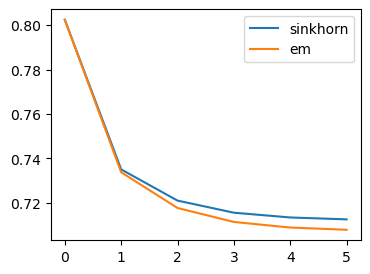

In [108]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(len(paths[0])), paths[0][:, 0], label='sinkhorn')
plt.plot(np.arange(len(paths[0])), paths[1][:, 0],  label='em')
plt.legend(loc='best')
plt.show()

In [109]:
%time simulate_em(0.70, 0.000, 1.0, N=2500, itr_num=10, disp=True, tq=False, total_runs=1)

should find:  1.0 (EOT)	 1.0 (MLE)
Finished iteration 0
[[ 0.98137481]
 [-0.98137481]] [[ 0.97724626]
 [-0.97724626]] [0.7 0.3] [0.7 0.3]
['sinkhorn em algorithm error', 0.0003468975531756291]
['em algorithm error', 0.0005177326746245936]
['negative log likelihood (sem algorithm)', -1.6881550602533621]
['negative log likelihood (em algorithm)', -1.6881487428138406]
CPU times: total: 3.31 s
Wall time: 1.33 s


array([[ 0.98137481, -0.98137481],
       [ 0.97724626, -0.97724626]])

In [110]:
# Run a few simulations
def estimate_theta_em(alpha, eps, theta, M = 3, N=1000, itr_num=10, total_runs=5, disp=True, tq=True):
    L = []
    for i in tqdm.trange(M) if tq else range(M):
        L.append(simulate_em(alpha, eps, theta, N, itr_num, total_runs, disp, tq=False))
    return np.array(L)

* Now we run many simulations with the right number of iterations etc. 
Mean of results must be superior to theta + std / sqrt(M). Thus careful for epsilon not to be too small

In [112]:
Xtmp = np.linspace(0.05,0.45, 20) # theta star
alphatmp = [0.55,0.65,0.75] # alpha star

Mtmp = 50 # number of independent runs (new data generated)
epstmp = 0.05 # epsilon for sensitivity

In [113]:
# initialize with the exact values of theta star (eps = 0)
all_the_results= [np.array([[np.array([ [[x, -x],[x, -x]], [[0,0], [0,0]] ] ) for x in np.linspace(0.05,0.45, 20)]])]

for a in alphatmp:
    all_the_results.append([])
    for x in Xtmp:
        res = estimate_theta_em(a, epstmp, x, Mtmp, 1500,6, disp=False, total_runs=5)
        all_the_results[-1].append(np.array([np.mean(res, axis=0), np.std(res, axis=0)]))
    all_the_results[-1] = np.array(all_the_results[-1])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


In [6]:
import pickle

In [144]:
# save results
import pickle
with open('all_the_results', 'wb') as handle:
    pickle.dump(all_the_results, handle)

In [117]:
# generate the true results for MLE and EOT
res_mle =  [[eval_ll_gmm(a + epstmp, x, a) -x for x in Xtmp] for a in alphatmp]
res_eot = [[theta_eot(a, epstmp, x) -x for x in Xtmp] for a in alphatmp]

In [139]:
def display_sensitivity_theory(a):
    
    plt.figure(figsize=(8,5))
    
    plt.plot(Xtmp, [np.array(x)/epstmp for x in res_mle[a]], label='log-likelihood')
    #plt.ylabel(r'$\theta_{\varepsilon} - \theta^*$')
    plt.ylabel(r'$\theta_{}\'(\varepsilon = 0)$')
    plt.xlabel(r'$\theta^*$')
    
    
    plt.plot(Xtmp, [np.array(x)/epstmp for x in res_eot[a]], label='Semi-Dual EOT')    
    
    plt.title(r'$(\alpha + \varepsilon) \mathcal{N}(\theta^*, 1) +(1 - \alpha - \varepsilon) \mathcal{N}(-\theta^*, 1)$,' + r'$\quad \quad (\alpha, \varepsilon) =$ ' +'({}, {})'.format(alphatmp[a], epstmp))
    plt.legend()
    
    plt.show()

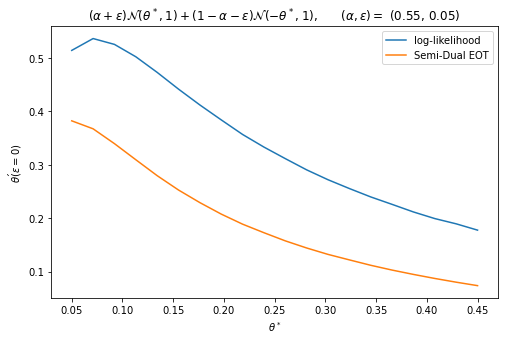

In [140]:
display_sensitivity_theory(0)

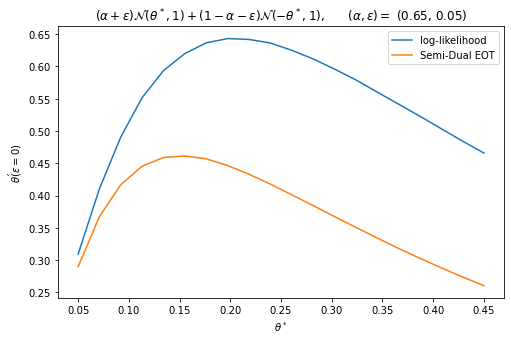

In [141]:
display_sensitivity_theory(1)

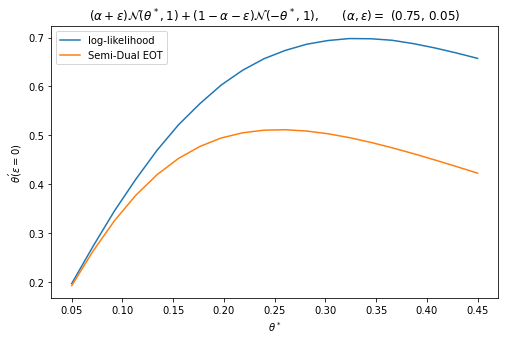

In [142]:
display_sensitivity_theory(2)

In [114]:
def display_sensitivity_analysis(a):
    fig, ax = plt.subplots(1,2,figsize=(20,7))
    
    MLE = 1
    ax[0].plot(Xtmp, res_mle[a], label='true')
    ax[0].errorbar(Xtmp, all_the_results[a+1][:, 0, MLE, 0] - Xtmp, all_the_results[a+1][:, 1, MLE, 0]/(np.sqrt(Mtmp)), label='EM')
    ax[0].set_title(r'$\theta_{MLE} - \theta^*$')
    ax[0].legend()
    
    MLE = 0
    ax[1].plot(Xtmp, res_eot[a], label='true')
    ax[1].errorbar(Xtmp, all_the_results[a+1][:, 0, MLE, 0] - Xtmp, all_the_results[a+1][:, 1, MLE, 0]/(np.sqrt(Mtmp)), label='Sinkhorn EM')
    ax[1].set_title(r'$\theta_{EOT} - \theta^*$')
    ax[1].legend()

    plt.suptitle(r'Parameters: $\alpha =$ ' + '{}'.format([0.55,0.65,0.75][a])+r', $\varepsilon = ' + '{}'.format(epstmp) + '$')
    plt.show()

In [119]:
def display_sensitivity_analysis_compare(a):
    plt.figure(figsize=(8,5))
    
    plt.ylabel(r'$\theta_{\varepsilon} - \theta^*$')
    plt.xlabel(r'$\theta^*$')
    
    plt.plot(Xtmp, res_mle[a], label='log-likelihood', color="blue")
    plt.plot(Xtmp, res_eot[a], label='Semi-Dual EOT', color='red')
    
    MLE = 1
    plt.errorbar(Xtmp, all_the_results[a+1][:, 0, MLE, 0] - Xtmp, all_the_results[a+1][:, 1, MLE, 0]/(np.sqrt(Mtmp)), label='EM',color="blue")
    MLE = 0
    plt.errorbar(Xtmp, all_the_results[a+1][:, 0, MLE, 0] - Xtmp, all_the_results[a+1][:, 1, MLE, 0]/(np.sqrt(Mtmp)), label='Sinkhorn EM', color='red')
    
    plt.title(r'$(\alpha + \varepsilon) \mathcal{N}(\theta^*, 1) +(1 - \alpha - \varepsilon) \mathcal{N}(-\theta^*, 1)$,' + r'$\quad \quad (\alpha, \varepsilon) =$ ' +'({}, {})'.format(alphatmp[a], epstmp))
    plt.legend()
    
    plt.show()

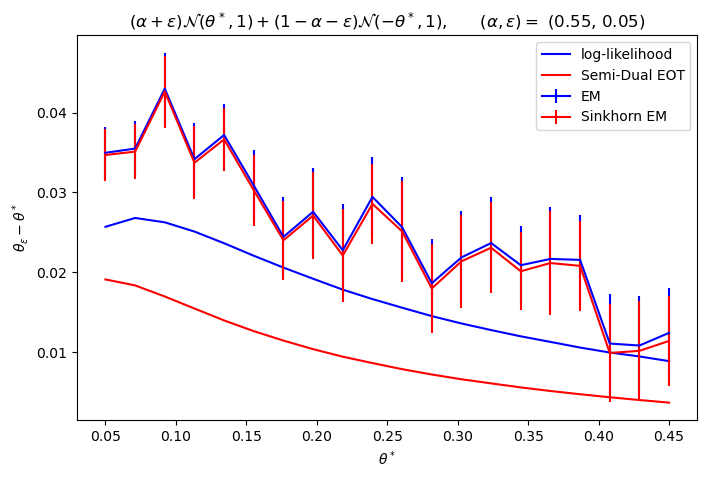

In [120]:
display_sensitivity_analysis_compare(0)

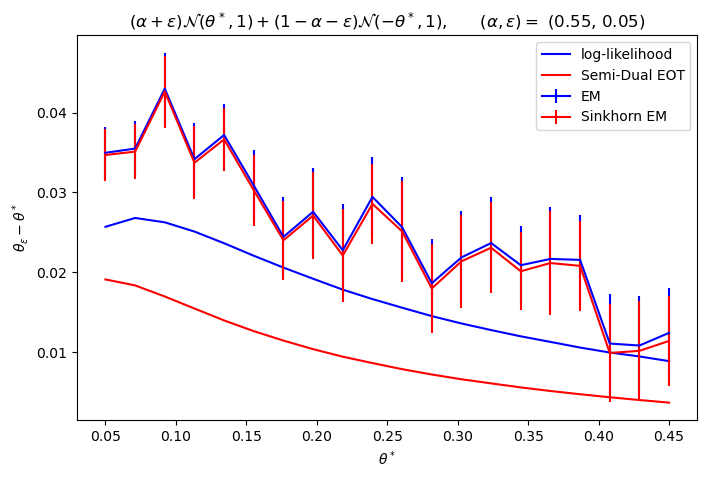

In [121]:
display_sensitivity_analysis_compare(0)

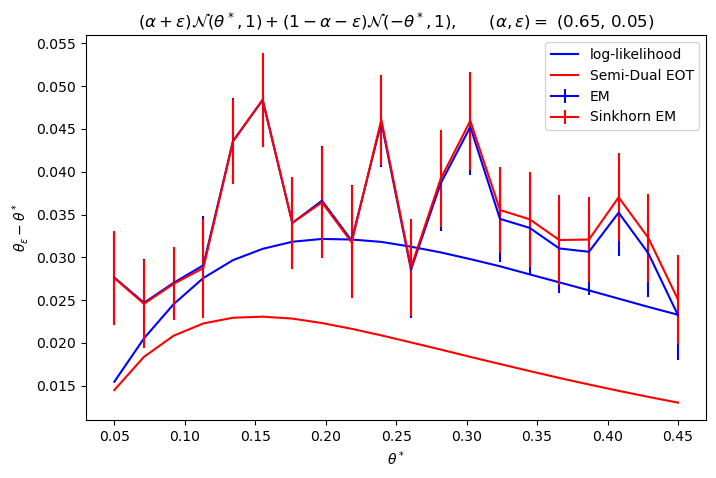

In [122]:
display_sensitivity_analysis_compare(1)

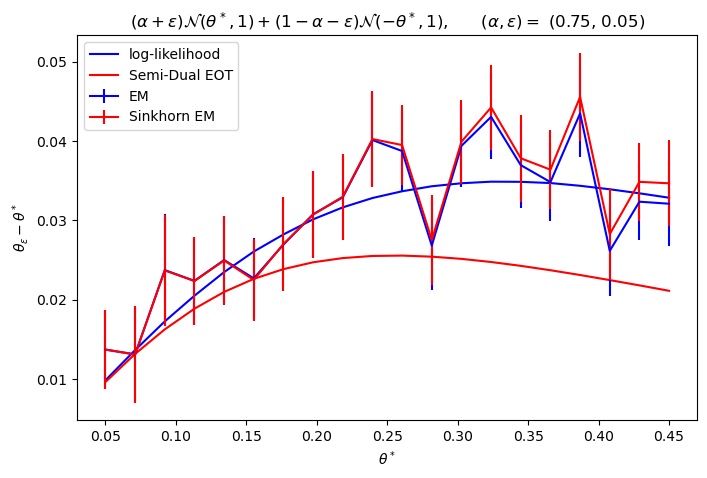

In [123]:
display_sensitivity_analysis_compare(2)

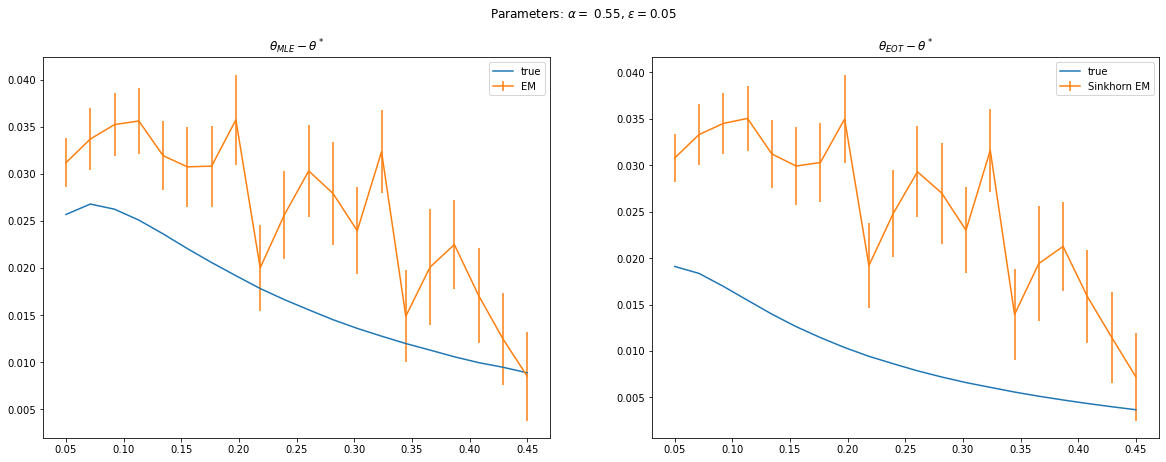

In [242]:
display_sensitivity_analysis(0)

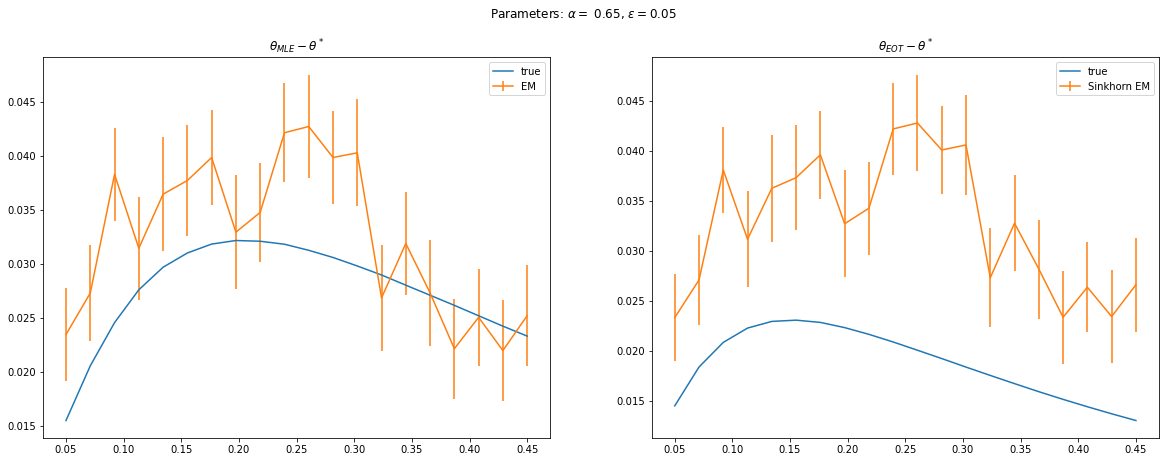

In [243]:
display_sensitivity_analysis(1)

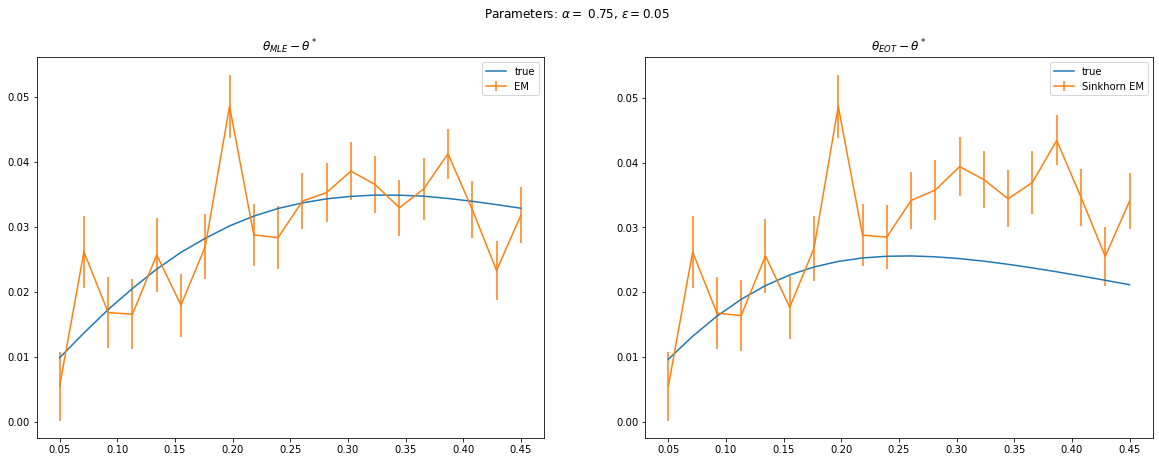

In [244]:
display_sensitivity_analysis(2)

## Some old code for variance of estimator etc.

In [291]:
def remove_outlier(tmp, std=2.0, set_to_zero=False):
    if len(tmp) <= 1:
        return tmp
    res=tmp[:]
    m, s = np.mean(res, axis=0), np.std(res, axis=0)
    new_mean = np.zeros((2,2))
    count = np.zeros((2,2))
    for k in range(len(res)):
        for i in range(2):
            for j in range(2):
                if (abs(res[k][i][j] - m[i][j]) < std*s[i][j]):
                    new_mean[i][j] += res[k][i][j]
                    count[i][j] +=1
    new_mean /= count
    for k in range(len(res)):
        for i in range(2):
            for j in range(2):
                if (abs(res[k][i][j] - m[i][j]) > std*s[i][j]):
                    if (set_to_zero):
                        res[k][i][j] = 0
                    else:
                        res[k][i][j] = new_mean[i][j]
    return res

In [81]:
res_tmp = remove_outlier(res, std = 2.0)

In [82]:
m, s = np.mean(res_tmp, axis=0), np.std(res_tmp, axis=0)

Verify EOT and MLE are AL, print variance

In [86]:
print(np.mean(res_eot[res_eot != 0], axis=0), np.mean(res_mle[res_mle != 0], axis=0))

1.072363887343177 1.063704436089573


EOT variance:	 0.07462925905373705
MLE variance:	 0.07399845907666554


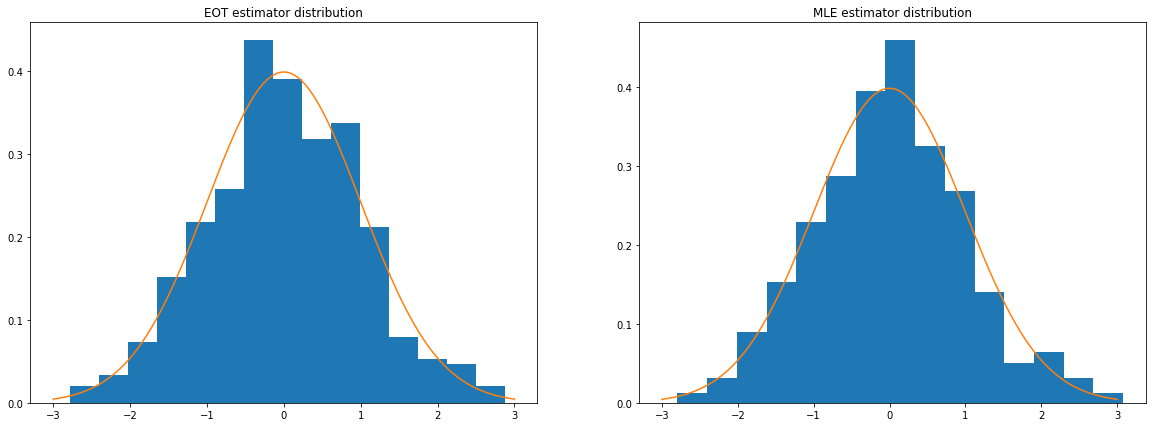

In [85]:
import scipy.stats as stats
fig,ax = plt.subplots(1,2,figsize=(20,7))

MLE = 0
X_tmp = np.linspace(-3,3, 100)


print('EOT variance:\t', s[MLE, 0])

res_eot = res[:, MLE, 0]
ax[0].hist((res_eot[res_eot != 0] - m[MLE,0]) / s[MLE,0], bins=15, density=True)
ax[0].plot(X_tmp, stats.norm.pdf(X_tmp, 0, 1))
ax[0].set_title('EOT estimator distribution')

MLE = 1
res_mle = res[:, MLE, 0]
print('MLE variance:\t', s[MLE, 0])
ax[1].hist((res_mle[res_mle != 0] - m[MLE,0]) / s[MLE,0], bins=15, density=True)
ax[1].plot(X_tmp, stats.norm.pdf(X_tmp, 0, 1))
ax[1].set_title('MLE estimator distribution')

plt.show()

In [212]:
res = estimate_theta_em(0.7, 0.005, 3.0, 15, 250,disp=False, total_runs=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


In [215]:
res = remove_outlier(res)

In [53]:
#Create a random mixture of M components with N samples on D dimensions. All parameters are sampled randomly from reasonable values
M = 4
N = 1000
D = 1
sigmas0 =  np.zeros((M , D, D))
sigmas =  np.zeros((M , D, D))

mus = np.zeros((M,D,1))
for k in range(M):

    
    #m = ortho_group.rvs(dim=D)
    #spectrum = np.diag(np.random.uniform(0,0.0*k+1, D))
    #mm = np.matmul(m.T, np.dot(spectrum,m))
    #sigmas0[k,:,:] = mm
    #sigmas[k,:,:] = np.matmul(mm,mm.T)
    sigmas0[k,:,:] = np.eye(D)*np.sqrt(2)
    sigmas[k,:,:] = np.eye(D)*2
    mu = np.random.normal(0,1,size=(D,1))*6
    mus[k,:,:] = mu
    
pis = np.ones(M)/M

datas = []
classes =[]
for n in range(M):
    m = int(pis[n]*N)
    data = mus[n,:,0] + np.matmul(sigmas0[n,:,:],np.random.normal(0,1,size=(m,D)).T).T
    datas.append(data)
    classes.append(np.zeros(m)+n)
datas2=np.array(datas).reshape(-1,D).T
classes=np.array(classes).flatten()


In [55]:
mus

array([[[-9.41045976]],

       [[-3.90749771]],

       [[10.53463659]],

       [[-7.69840735]]])

In [ ]:
mus_sinkhorn = []
mus_em = []
mus_km =[]

for s in range(10):
    np.random.seed(s)
    update = {'pi':False,'mu':True,'sigma':False}
    #update all parameters
    var0 =  {'pi':pis,'mu':None, 'sigma':sigmas}
    #random initial values for all quantities (uniform weights)

    
    pi_em, mu_em, sigma_em,mu_all_em,H_em,liks_em,_,sigma_all_em,pi_all_em,_,props = sinkhorn_em_new(datas2,M,itr_num=100,seed=s,var0 =var0,
                                                                                           update = update,tol=1e-20,
                                                                         update_em_pi=True, 
                                                                         do_sinkhorn=False,tol_sigma=1e-1, init_mu_type='subsample')
   
    pi_sinkhorn, mu_sinkhorn, sigma_sinkhorn,mu_all_sinkhorn,H_sinkhorn,liks_sinkhorn,sinkhorn_loss,sigma_all_sinkhorn,pi_all_sinkhorn,ho,prop = sinkhorn_em_new(datas2,M,itr_num=100,
    seed=s,var0 =var0,update = update,tol=1e-20,
    update_em_pi=True,do_sinkhorn=True,tols=1e-5,
    n_iter_sink = 100,tol_sigma=1e-2,init_mu_type='subsample')
    
    print('Finished iteration '+str(s))
    print(['em algorithm error',error(mu_em,mus[:,:,0],pi_em,np.ones(M)/M)])
    print(['sinkhorn em algorithm error',error(mu_sinkhorn,mus[:,:,0],pi_sinkhorn,np.ones(M)/M)])
    
    print(['negative log likelihood (em algorithm)',liks_em[-1]])
    print(['negative log likelihood (sem algorithm)',liks_sinkhorn[-1]])
    
    kmeans = KMeans(init="random", n_clusters=M, max_iter=10000).fit(datas2.T)
        
        
        
    mus_km.append(kmeans.cluster_centers_)
    mus_em.append(mu_em)
    mus_sinkhorn.append(mu_sinkhorn)
    print([error(kmeans.cluster_centers_,mus[:,:,0],np.ones(M)/M,np.ones(M)/M)])
        



In [ ]:

fig,ax = plt.subplots(1,3,figsize=(20,7))

for i in range(3):
    ax[i].scatter(datas2[0,:],datas2[1,:],5,classes,cmap='jet')
    #plt.scatter(mu_all_sinkhorn[0][:,0],mu_all_sinkhorn[0][:,2])
    ax[i].scatter(mus[:,0],mus[:,1],100,marker='x',color='black')
    #plt.scatter(mu_em[:,0],mu_em[:,1])

    
ax[0].scatter(mu_sinkhorn[:,0],mu_sinkhorn[:,1],300,marker='o',color='red',label='Inferred')
ax[0].set_title('Sinkhorn EM',fontsize=20)
ax[1].scatter(mu_em[:,0],mu_em[:,1],300,marker='o',color='red')
ax[1].set_title('EM',fontsize=20)
ax[2].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],300,marker='o',color='red')
ax[2].set_title('Kmeans++',fontsize=20)
#plt.scatter(mu_em[:,0],mu_em[:,2])
for i in range(3):
     ax[i].scatter(mus[:,0],mus[:,1],300,marker='x',color='black',linewidth=5,label='True')
ax[0].legend(fontsize=20,frameon=False)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
#plt.savefig('unequal.eps')

In [ ]:
for n in range(20):
    fig,ax = plt.subplots(1,3,figsize=(20,7))

    for i in range(3):
        ax[i].scatter(datas2[0,:],datas2[1,:],5,classes,cmap='jet')
        #plt.scatter(mu_all_sinkhorn[0][:,0],mu_all_sinkhorn[0][:,2])
        ax[i].scatter(mus[:,0],mus[:,1],100,marker='x',color='black')
        #plt.scatter(mu_em[:,0],mu_em[:,1])


    ax[0].scatter(mus_sinkhorn[n][:,0],mus_sinkhorn[n][:,1],200,marker='o',color='red',label='Inferred')
    ax[0].set_title('Sinkhorn EM',fontsize=20)
    ax[1].scatter(mus_em[n][:,0],mus_em[n][:,1],200,marker='o',color='red')
    ax[1].set_title('EM',fontsize=20)
    ax[2].scatter(mus_km[n][:,0], mus_km[n][:,1],200,marker='o',color='red')
    ax[2].set_title('Kmeans++',fontsize=20)
    #plt.scatter(mu_em[:,0],mu_em[:,2])
    for i in range(3):
         ax[i].scatter(mus[:,0],mus[:,1],300,marker='x',color='black',linewidth=5,label='True')
    ax[0].legend(fontsize=20,frameon=False)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    #plt.savefig('unequal' +str(n) +'.eps')

In [ ]:

fig,ax = plt.subplots(1,3,figsize=(20,7))

for i in range(3):
    ax[i].scatter(datas2[0,:],datas2[1,:],5,classes,cmap='jet')
    #plt.scatter(mu_all_sinkhorn[0][:,0],mu_all_sinkhorn[0][:,2])
    ax[i].scatter(mus[:,0],mus[:,1],100,marker='x',color='black')
    #plt.scatter(mu_em[:,0],mu_em[:,1])

    
ax[0].scatter(mu_sinkhorn[:,0],mu_sinkhorn[:,1],300,marker='o',color='red',label='Inferred')
ax[0].set_title('Sinkhorn EM',fontsize=20)
ax[1].scatter(mu_em[:,0],mu_em[:,1],300,marker='o',color='red')
ax[1].set_title('EM',fontsize=20)
ax[2].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],300,marker='o',color='red')
ax[2].set_title('Kmeans++',fontsize=20)
#plt.scatter(mu_em[:,0],mu_em[:,2])
for i in range(3):
     ax[i].scatter(mus[:,0],mus[:,1],300,marker='x',color='black',linewidth=5,label='True')
ax[0].legend(fontsize=20,frameon=False)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
#plt.savefig('equal1.eps')

In [ ]:

fig,ax = plt.subplots(1,3,figsize=(20,7))

for i in range(3):
    ax[i].scatter(datas2[0,:],datas2[1,:],5,classes,cmap='jet')
    #plt.scatter(mu_all_sinkhorn[0][:,0],mu_all_sinkhorn[0][:,2])
    ax[i].scatter(mus[:,0],mus[:,1],100,marker='x',color='black')
    #plt.scatter(mu_em[:,0],mu_em[:,1])

    
ax[0].scatter(mu_sinkhorn[:,0],mu_sinkhorn[:,1],300,marker='o',color='red',label='Inferred')
ax[0].set_title('Sinkhorn EM',fontsize=20)
ax[1].scatter(mu_em[:,0],mu_em[:,1],300,marker='o',color='red')
ax[1].set_title('EM',fontsize=20)
ax[2].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],300,marker='o',color='red')
ax[2].set_title('Kmeans++',fontsize=20)
#plt.scatter(mu_em[:,0],mu_em[:,2])
for i in range(3):
     ax[i].scatter(mus[:,0],mus[:,1],300,marker='x',color='black',linewidth=5,label='True')
ax[0].legend(fontsize=20,frameon=False)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
#plt.savefig('equal2.eps')